# Homework 7 (Gathering and Preparing Data for Visualization)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Problem 1 (2 points)

Write a Python script to download the HTML from https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table

Read the olympic medals table into a Pandas dataframe from the HTML file and show the top ten rows

In [2]:
# Data Discovery:
# dfs = pd.read_html("https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table")
# len(dfs)
# for i, df in enumerate(dfs):
#     print(i, df.columns)

# For simplicity, I'm directly storing the medal's table, ignoring all other data
data_2024 = pd.read_html("https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table")[3]

data_2024.head(n = 10)

,Rank,NOC,Gold,Silver,Bronze,Total
0,1,United States‡,40,44,42,126
1,2,China,40,27,24,91
2,3,Japan,20,12,13,45
3,4,Australia,18,19,16,53
4,5,France*,16,26,22,64
5,6,Netherlands,15,7,12,34
6,7,Great Britain,14,22,29,65
7,8,South Korea,13,9,10,32
8,9,Italy,12,13,15,40
9,10,Germany,12,13,8,33


### Problem 2 (3 points)

Repeat the previous exercise with the 2020 Summer Olympics medal table, available at https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table 

**Combine** the 2024 and 2020 olympics tables into a single dataframe 
* Keep a column for the country name (no need to keep the Rank column) 
* **Add** medal counts together between years for the same country (add Gold to Gold, Silver to Silver, etc.) 
* Check for duplicate country names that could have small variations in spelling / presentation between tables

Some things to be aware of
* Each table has a "Totals" row that should be removed
* Decorators like * and ‡ after country names may vary from year to year
* Any null values for medal counts can be replaced with 0 

In [ ]:
# Data Discovery:
# data = pd.read_html("https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table")
# len(data)
# for table in data[1]:
#     print(table.columns)
# data[3] # <- The right table

raw_data = [
    pd.read_html("https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table")[3],
    pd.read_html("https://en.wikipedia.org/wiki/2020_Summer_Olympics_medal_table")[3]
]

# For this transformation, I created a new dataframe object with NOC as index and dropping the Rank column
from re import match
def simplify_NOC(entry):
    simplified = match(r"\w*(\s\w*)*", entry)
    return simplified[0] if simplified else simplified
    
cleaned_data = []
for table in raw_data:
    temp = table.drop(columns="Rank")
    temp["NOC"] = temp.NOC.apply(simplify_NOC)
    cleaned_data.append(temp.set_index("NOC"))

transformed_data = cleaned_data[0].add(cleaned_data[1], fill_value=0)
#transformed_data
plt.barh(transformed_data)

### Problem 3 (3 points)

Continue the previous exercise, but download and join together all Summer Olympic medal tables from 2000 to 2024. 
* Links to medal tables are available here:  https://en.wikipedia.org/wiki/Category:Summer_Olympics_medal_tables 

Be mindful of slight variations from year to year, including things like
* Column names of tables
* Changes in country name (e.g. Russia to ROC) 

In [131]:
raw_data = {
    year: pd.read_html(f"https://en.wikipedia.org/wiki/{year}_Summer_Olympics_medal_table")[3]
        for year in range(2000,2025,4)
}
# for data in raw_data.values():
# print(data.columns)

from re import match
def simplify_NOC(entry):
    simplified = match(r"\w*(\s\w*)*", entry)
    return simplified[0] if not isinstance(simplified, str) else simplified
def normalize_russia(entry):
    return "ROC" if entry == "Russia" else entry 
#raw_data
cleaned_data = {}
for year, table in raw_data.items():
    temp = table.drop(columns="Rank")
    if "NOC" in table.columns:
        temp["NOC"] = temp.NOC.apply(simplify_NOC).apply(normalize_russia)
        cleaned_data[year] = temp.set_index("NOC")
    else:
        temp["NOC"] = temp.Nation.apply(simplify_NOC).apply(normalize_russia)
        cleaned_data[year] = temp.set_index("NOC").drop(columns="Nation")

transformed_data = pd.DataFrame()
for cleaned_year_data in cleaned_data.values():
    transformed_data = transformed_data.add(cleaned_year_data, fill_value=0)
#list(transformed_data.index)

### Problem 4 (2 points)

Using the data table created in problem 3, create two visualizations (following visualization best practices):
1. Display the top 5 countries by **total** medal count
2. Display the top 5 countries by **gold** medal count 


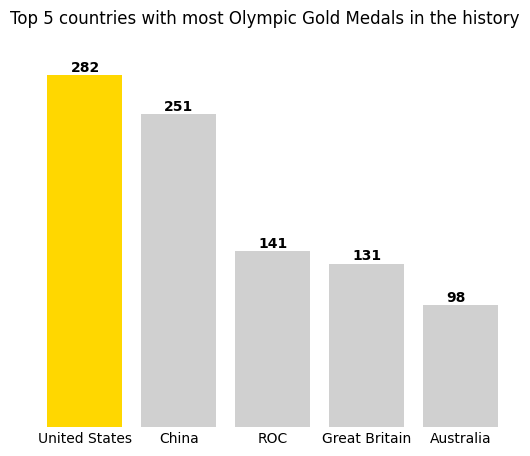

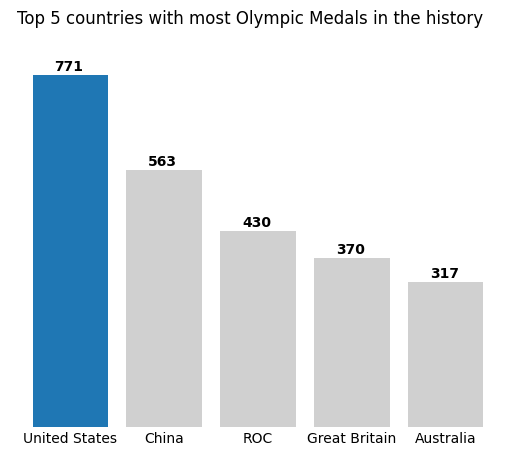

In [130]:
sorted_by_gold = transformed_data.sort_values("Gold", ascending=False).drop("Totals ").astype("Int32")
max_gold = sorted_by_gold.Gold.max()
sorted_by_total = transformed_data.sort_values("Total", ascending=False).drop("Totals ").astype("Int32")
max_total = sorted_by_total.Total.max()

def plot_gold():
    rectangles = plt.bar(
        sorted_by_gold.head(n=5).index, sorted_by_gold.head(n=5).Gold,
        color=["#FFD700" if amount == max_gold else "#D0D0D0"
                for amount in sorted_by_gold.head(n=5).Gold.values]
    )
    for rectangle, amount in zip(rectangles, sorted_by_gold.head(n=5).Gold.values):
        plt.annotate(
            amount,
            (
                rectangle.get_x()+rectangle.get_width()/3.25,
                rectangle.get_height()+3
            ),
            weight="bold"
        )
    axes = plt.gca()
    axes.spines[:].set_visible(False)
    axes.set_yticks([])
    plt.suptitle("Top 5 countries with most Olympic Gold Medals in the history")
    plt.tick_params(axis="x", length=0)
    plt.show()

plot_gold()

def plot_totals():
    rectangles = plt.bar(
        sorted_by_total.head(n=5).index, sorted_by_total.head(n=5).Total,
        color=["tab:blue" if amount == max_total else "#D0D0D0"
                for amount in sorted_by_total.head(n=5).Total.values]
    )
    for rectangle, amount in zip(rectangles, sorted_by_total.head(n=5).Total.values):
        #print(amount, rectangle.get_x(), rectangle.get_height())
        plt.annotate(
            amount,
            (
                rectangle.get_x()+rectangle.get_width()/3.5,
                rectangle.get_height()+10
            ),
            weight = "bold"
        )
    axes = plt.gca()
    axes.spines[:].set_visible(False)
    axes.set_yticks([])
    plt.suptitle("Top 5 countries with most Olympic Medals in the history")
    plt.tick_params(axis="x", length=0)
    plt.show()

plot_totals()


### Bonus Problem (2 points)

Using the data tables gathered from problems 1 to 3, create two additional visualizations (follwing best practices):
1. Show the trends in **total** medal count of the top 5 countries (problem 4 part 1) from 2000 to 2024
2. Show the trends in **gold** medal count of the top 5 countries (problem 4 part 2) from 2000 to 2024

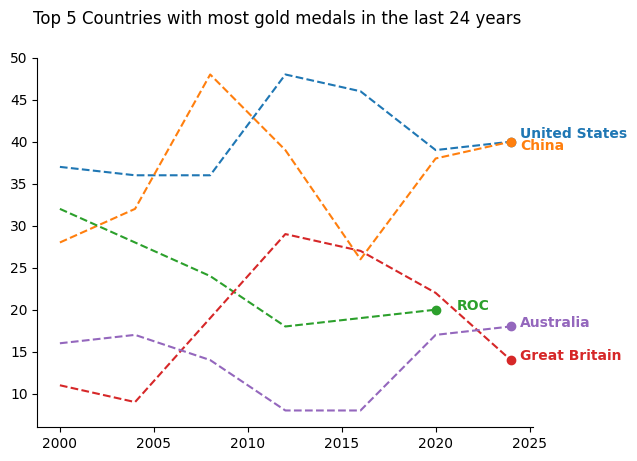

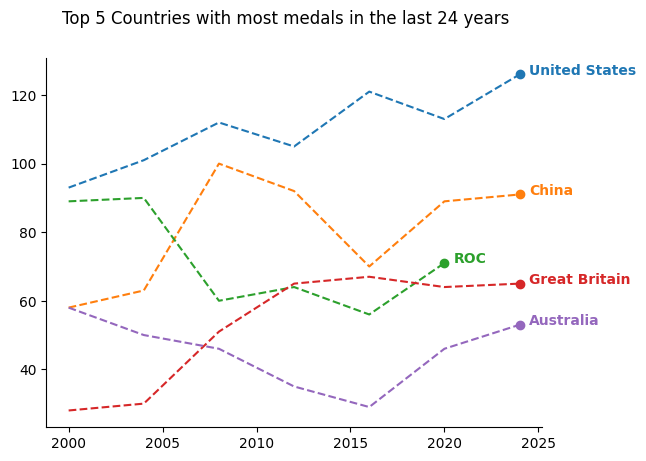

In [120]:
from numpy import array
top_5 = ["United States", "China", "ROC", "Great Britain", "Australia"]

data_per_year = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(
        [top_5 * 2, ["Gold", "Totals"] * 5]
    ), columns=[year for year in range(2000,2025,4)]
)

for year, data in cleaned_data.items():
    for country in top_5:
        if year == 2024 and country == "ROC":
            continue # ROC didn't participate in 2024 Games because of the ban.
        else:
            data_per_year.loc[(country, "Gold"), (year,)] = cleaned_data[year].loc[country, "Gold"]
            data_per_year.loc[(country, "Totals"), (year,)] = cleaned_data[year].loc[country, "Total"]

def clean_xy_coors(country, xy_coors: tuple, metal: str):
    if metal != "Gold":
        return xy_coors + array([.5,0])
    if country == "ROC":
        return xy_coors + array([1.1,0])
    elif country == "United States":
        return xy_coors + array([.5,.5])
    elif country == "China":
        return xy_coors + array([.5,-1])
    else:
        return xy_coors + array([.5,0])          
            
def plot_line(metal: str):
    for country in top_5:
        line = plt.plot(
            data_per_year.loc[country, metal], label=country,
            linestyle='--', marker='o', markevery=[5] if country == "ROC" else [6]
        )
        xy_coors = clean_xy_coors(
            country,
            array(
                line[0].get_xydata()[-1] if country != "ROC" else line[0].get_xydata()[-2]
            ),
            metal
        )
        plt.annotate(country, xy_coors, c=line[0].get_c(), weight="bold")
        
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.suptitle(
        "Top 5 Countries with most " + \
        ("gold " if metal == "Gold" else "") + \
        "medals in the last 24 years"
    )
    plt.show()
        
plot_line("Gold")
plot_line("Totals")